## Imports

In [1]:
import sys
sys.path.append('../')
import gc
import pandas as pd
import numpy as np

from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
# import plotly.io as pio
# pio.renderers.default = "svg"


cleaner = CleanDataFrame()
analyzer = Analysis()
plotters = Plotters(w=6, h=4)

# pd.options.plotting.backend = 'matplotlib'
plt.rcParams.update({'font.size': 24})
# plt.rcParams.update({'xtick.labelsize': 'large'})
# plt.rcParams.update({'ytick.labelsize': 'large'})
plt.rcParams.update({'legend.fontsize': 24})
%matplotlib inline
# plt.rcParams.keys()



## Fetch the dataframes

In [2]:
# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'merged_v1'
repo = '../'

train_df = DataLoader.dvc_get_data(data_path, version, repo)
train_df['Date'] = pd.to_datetime(train_df['Date'])
# Finally load the test data
data_path = 'data/merged/test.csv'
version = 'merged_v1'
repo = '../'

test_df = DataLoader.dvc_get_data(data_path, version, repo)
test_df['Date'] = pd.to_datetime(test_df['Date'])

DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/train.csv | version: merged_v1 | from: ../
DataLoaderLogger - INFO - DVC: CSV file read with path: data/merged/test.csv | version: merged_v1 | from: ../


# Question Guided EDA


## 1. Are the promotions distributed similarly in both training and test sets?

YES


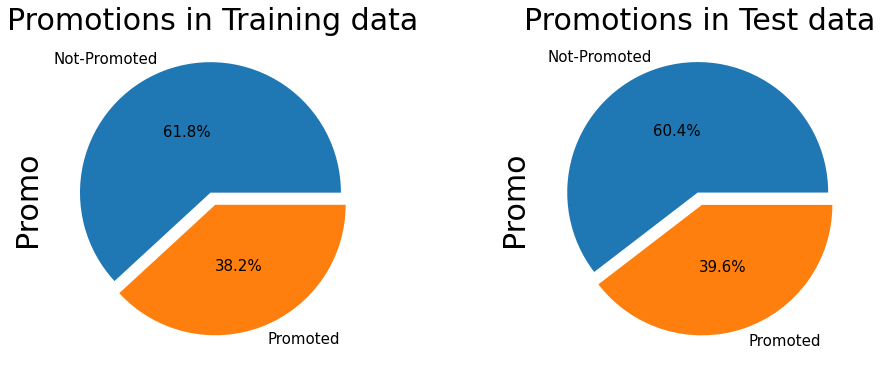

In [3]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

lable_font_size = 30
textprops = {"fontsize":15}
labels = {'Not-Promoted': 0, 'Promoted': 1}
train_promo_count = train_df["Promo"].value_counts().to_frame()

# plt.title("Ratio of overall promotions",
#           fontsize=20, loc='left')
axs[0].pie(data=train_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )
axs[0].set_label(labels)
axs[0].set_ylabel('Promo', fontsize=lable_font_size)
# axs[0].set_label(labels, fontsize=lable_font_size)
axs[0].set_title('Promotions in Training data', fontsize=lable_font_size)

test_promo_count = test_df["Promo"].value_counts().to_frame()
axs[1].pie(data=test_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )

axs[1].set_ylabel('Promo', fontsize=lable_font_size)
axs[1].set_title('Promotions in Test data', fontsize=lable_font_size)



print("YES")


## 2. What does sales behavior look like before, during and after holidays?

To answer this, I will first look at how the holidays are distributed.

*StateHoliday*

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass

I will take Christmass for now and explore

In [4]:
christmas = train_df.query("StateHoliday=='c'")
christmas_dates = christmas.groupby('Date')['Date'].unique().index
christmas_dates = pd.to_datetime(christmas_dates)
print(f"There are {christmas_dates.shape[0]} christmas_dates\n{christmas_dates}")
# christmas_dates = [a[0] for a in christmas_dates.tolist()]

There are 4 christmas_dates
DatetimeIndex(['2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26'], dtype='datetime64[ns]', name='Date', freq=None)


In [5]:
grouped_by_date = train_df.groupby('Date')[['Customers', 'Sales', 'SalesPerCustomer']]
grouped_by_date = grouped_by_date.sum()
grouped_by_date.head()

,Customers,Sales,SalesPerCustomer
Date,,,
2013-01-01,19491,97235,84.826752
2013-01-02,834075,6949829,9708.032399
2013-01-03,761040,6347820,9709.819394
2013-01-04,782137,6638954,9818.033076
2013-01-05,687472,5951593,9971.772244


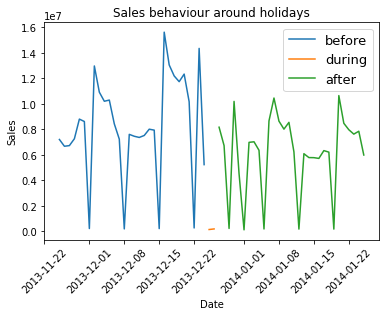

In [7]:
# before_christmass = pd.DataFrame()
# after_christmass = pd.DataFrame()
# during_christmass = pd.DataFrame()
# for i in range(0, len(christmas_dates), 2):
before_christmass_idx = grouped_by_date[grouped_by_date.index < christmas_dates[0]].index[-30:]
after_christmass_idx = grouped_by_date[grouped_by_date.index > christmas_dates[1]].index[:30]
during_christmass_idx = christmas_dates[:2]


before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]

# sns.set()
# sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
# sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
# ax = sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])

# before_christmass_idx = before_christmass_idx, grouped_by_date[grouped_by_date.index < christmas_dates[2]].index[-10:]
# after_christmass_idx = after_christmass_idx, grouped_by_date[grouped_by_date.index > christmas_dates[3]].index[:10]
# during_christmass_idx = during_christmass_idx, christmas_dates[2:3]


# before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
# after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
# during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]



# sns.set()
sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
ax = sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])
ax.set_title("Sales behaviour around holidays")
plt.xticks(rotation = 45) 
ax.legend(['before', 'during', 'after'], fontsize=13)

# before_christmass

In [8]:
holiday_dates = train_df[(~train_df["StateHoliday"].isin(['0']) | train_df['SchoolHoliday']!=0)]['Date'].unique()
holiday_dates.shape


(487,)

## 3. Are there any seasonal (Christmas, Easter etc) purchase behaviours?

In [9]:
christmas = train_df.query("StateHoliday=='c'")
christmas_dates = christmas.groupby('Date')['Date'].unique().values
print(f"There are {christmas_dates.shape[0]} christmas_dates")
christmas_dates = [a[0] for a in christmas_dates.tolist()]

easter = train_df.query("StateHoliday=='b'")
easter_dates = easter.groupby('Date')['Date'].unique().values
print(f"There are {easter_dates.shape[0]} easter_dates")
easter_dates = [a[0] for a in easter_dates.tolist()]

public_holiday = train_df.query("StateHoliday=='a'")
public_holiday_dates = public_holiday.groupby('Date')['Date'].unique().values
print(f"There are {public_holiday_dates.shape[0]} public_holiday_dates")
public_holiday_dates = [a[0] for a in public_holiday_dates.tolist()]

# holiday_dates.shape
# holiday_dates = pd.to_datetime(holiday_dates)


There are 4 christmas_dates
There are 6 easter_dates
There are 27 public_holiday_dates


In [3]:
# grouped_by_date = train_df.groupby('Date')['Sales'].sum().to_frame()
# ax = px.line(grouped_by_date)
# colors = ['black', 'green', 'red']
# holiday_names = ['Public', 'Christmas', 'Easter']
# for idx, holiday_type in enumerate([public_holiday_dates, christmas_dates, easter_dates]):
#     for holiday in holiday_type:
#         ax.add_vline(x=holiday, line={'color': colors[idx]})

# ax.show()


In [ ]:
# # customers
# sns.catplot(data = train_df, x = 'Month', y = "Sales", 
#                col = 'DayOfWeek', # per store type in cols
#                hue = 'StoreType',
#                row = 'StoreType') 

## 4. Correlation between sales and number of customers

Text(0.5, 1.0, 'Correlation map of selected sales and store features')

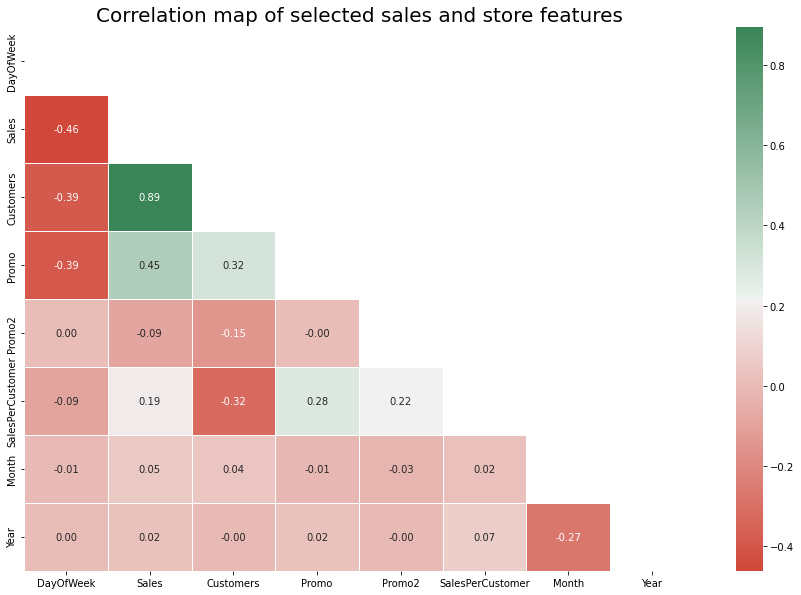

In [12]:
df_correlation = train_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
                           'Promo2', 'SalesPerCustomer', 'Month', 'Year',
                           'StateHoliday', 'Assortment', 'StoreType',
                           'PromoInterval']]

df_correlation=df_correlation.drop('Open', axis = 1)
upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(15, 500, as_cmap=True))
ax.set_title("Correlation map of selected sales and store features", fontsize=20)


## 5. How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?


In [13]:
grouped_by_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].describe().transpose()
grouped_by_promo

Promo,0,1
count,467463.000000,376875.000000
mean,5929.826183,8228.739731
std,2629.269229,3175.253594
min,46.000000,133.000000
25%,4242.000000,6070.000000
50%,5459.000000,7650.000000
75%,7004.000000,9686.000000
max,41551.000000,38722.000000


Text(0.5, 1.0, 'Average Sales vs Promo')

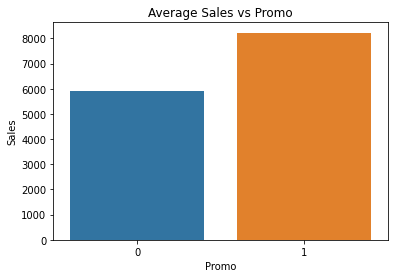

In [14]:
# sum_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].sum().to_frame()
# ax = sns.barplot(data=sum_sale_promo, x=sum_sale_promo.index, y='Sales')
# ax.set_title("Total Sales and Promo")

mean_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['Sales'].mean().to_frame()
ax = sns.barplot(data=mean_sale_promo, x=mean_sale_promo.index, y='Sales')
ax.set_title("Average Sales vs Promo")

Text(0.5, 1.0, 'Total Customers vs Promo')

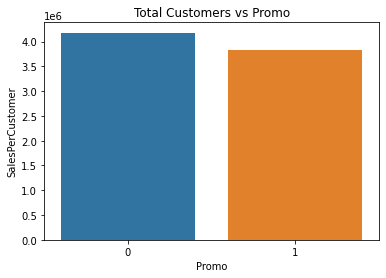

In [15]:
total_customers_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby('Promo')['SalesPerCustomer'].sum().to_frame()
ax = sns.barplot(data=total_customers_promo, x=total_customers_promo.index, y='SalesPerCustomer')
ax.set_title("Total Customers vs Promo")

The promos do increase the sales, but the number of customers is actually decreases. 

But it doesn't mean it's a bad thing since customers are actually spending more during tha Promos.

Since there are fewer customers during the Promos, I conclude that some are not too happy about the promos and choose to stay away.

## 6. Could the promos be deployed in more effective ways? Which stores should promos be deployed in?


In [ ]:
grouped_by_store = train_df.groupby('Store')[['Sales', 'Customers']].sum()
grouped_by_store.head()

Let's look at the distribution of Sales and Customers per store

In [ ]:
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Sales')
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Customers')
plt.legend(['Sales', 'Customers'], fontsize=14)

## 8. Which stores are opened on all weekdays? How does that affect their sales on weekends? 


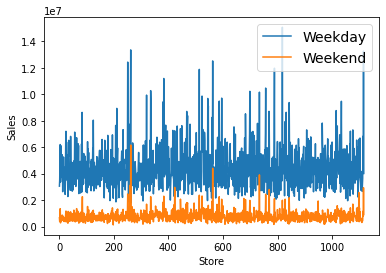

In [16]:
# stores_open_on_weekdays = train_df.query("DayOfWeek!=7 & DayOfWeek!=6 & Open==1")['Store'].unique()
stores_open_on_weekdays = train_df.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(stores_open_on_weekdays) &train_df['Open']==1 & ~train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(stores_open_on_weekdays) &train_df['Open']==1 & train_df['DayOfWeek'].isin([6,7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
plt.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')

I have plotted the weekday and weekend sales for store that were open in both type of days. Sales on Weekends are significanly lower than on weekdays.

But, I can't be certain that this has to do with the fact that they were also open during the week days. 

Most stores are closed on weekends, so sales are generally down on weekends.

In [ ]:
train_df['DayOfWeek']>5

## 9. How does assortment type affects sales?

Since I am grouping with Assortment, taking the sum would be missleading. That is because, there won't be equal samples for each group. So, I will take the mean.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


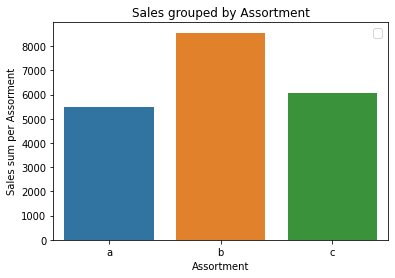

In [32]:
grouped_by_year_assortment = train_df.groupby(['Assortment'])['Sales'].mean().to_frame()
ax = sns.barplot(x=grouped_by_year_assortment.index, 
            y=grouped_by_year_assortment['Sales'].values,
            # xlabel="Assortment", 
            # ylabel='Sales sum per Assorment', 
            # title='Sales grouped by Assortment'
            )
ax.set_ylabel('Sales sum per Assorment')
ax.set_title('Sales grouped by Assortment')
plt.legend(fontsize=12)
# grouped_by_year_assortment['Sales'].values


Assortment type 'b' Has the largest mean sales followed by 'c' and 'a'

## 10. How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

Text(0.5, 0, 'CompetitionDistance')

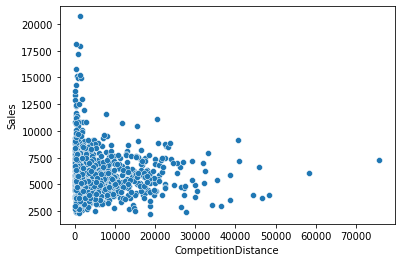

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# comp_dist = scaler.fit_transform(
comp_dist = train_df.groupby('Store')[['CompetitionDistance']].min()#)[:, 0]
# store_sales = scaler.fit_transform(
store_sales = train_df.groupby('Store')[['Sales']].mean()#)[:, 0]


ax=sns.scatterplot(x=comp_dist.values[:, 0], y=store_sales.values[:, 0])
ax.set_ylabel('Sales')
ax.set_xlabel('CompetitionDistance')

In [ ]:
train_df.columns